In [1]:
from iotbx.map_manager import map_manager as MapManager
from mmtbx.model import manager as ModelManager
from iotbx.data_manager import DataManager
from iotbx.map_model_manager import map_model_manager as MapModelManager
from mmtbx.maps.correlation import five_cc

In [2]:
import os
import pickle
from multiprocessing import Pool
from collections import Counter
import numpy as np
import gzip
import shutil

In [3]:
nucleotide_entries_path = "data/nucleotide_entries.pkl"
working_directory = "../maps_and_models_ligand_extracted"

In [4]:
entry_ids = os.listdir(working_directory)

with open(nucleotide_entries_path,"rb") as fh:
    nucleotide_entries = pickle.load(fh)
nucleotide_entries_dict = {entry.entry:entry for entry in nucleotide_entries if entry.entry in entry_ids}

In [10]:
five_cc_obj_dict = {}
for entry_id in entry_ids:
    entry = nucleotide_entries_dict[entry_id]
    entry_directory = working_directory+"/"+entry_id
    contents = os.listdir(entry_directory)
    ligand_ids = list(set([f.split(".")[0] for f in contents if "ligand" in f]))
    
    for ligand_id in ligand_ids:
        ligand_map_path = entry_directory+"/"+ligand_id+".map"
        ligand_model_path = entry_directory+"/"+ligand_id+".pdb"
        dm = DataManager()
        dm.process_model_file(ligand_model_path)
        model_manager = dm.get_model()
        map_manager = MapManager(ligand_map_path)
        mmm = MapModelManager(map_manager=map_manager, model=model_manager)

        d_min = entry.resolution
        five_cc_obj = five_cc(
                       mmm.map_data(),
                       mmm.model().get_xray_structure(),
                       d_min,
                       box=None,
                       keep_map_calc=False,
                       compute_cc_box=False,
                       compute_cc_image=False,
                       compute_cc_mask=True,
                       compute_cc_volume=True,
                       compute_cc_peaks=True)

        five_cc_obj_dict[entry_id+"_"+ligand_id] = five_cc_obj

    

In [12]:
cc = five_cc_obj_dict[five_cc_obj_dict.keys()[0]]

In [18]:
cc_mask_values = []
for key,value in five_cc_obj_dict.items():
    cc_mask = value.result()["cc_mask"]
    cc_mask_values.append(cc_mask)

In [20]:
cc_mask_array = np.array(cc_mask_values)

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([ 10.,   2.,   2.,   2.,  13.,  32.,  62., 109., 137.,  35.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

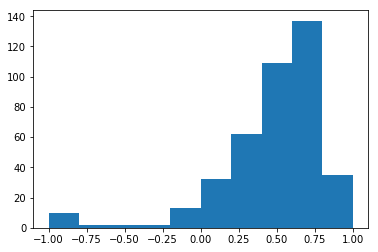

In [23]:
plt.hist(cc_mask_array)